# BTC-USD @5min

In [7]:
# PARAMS:
BC5M_FILENAME = './data_clean/btc.300s.cbpro.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [8]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

In [10]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

> size: 387948


datetime    datetime64[ns]
low                float64
high               float64
open               float64
close              float64
volume             float64
dtype: object

,datetime,low,high,open,close,volume
timestamp,,,,,,
1422745200,2015-01-31 23:00:00,224.51,225.69,225.38,224.51,29.638700
1422745500,2015-01-31 23:05:00,224.00,225.59,224.62,224.00,52.189176
1422745800,2015-01-31 23:10:00,221.99,223.92,223.91,221.99,40.262566
1422746100,2015-01-31 23:15:00,218.00,222.00,222.00,218.00,163.490760
1422746400,2015-01-31 23:20:00,217.11,218.89,217.92,218.22,96.317898


,datetime,low,high,open,close,volume
timestamp,,,,,,
1539128100,2018-10-09 23:35:00,6590.30,6593.48,6591.54,6590.30,17.148190
1539128400,2018-10-09 23:40:00,6586.55,6590.31,6590.31,6589.30,15.269094
1539128700,2018-10-09 23:45:00,6589.29,6589.69,6589.30,6589.48,12.466310
1539129000,2018-10-09 23:50:00,6589.47,6592.81,6589.48,6591.85,14.972801
1539129300,2018-10-09 23:55:00,6589.47,6592.81,6591.84,6589.48,31.305392


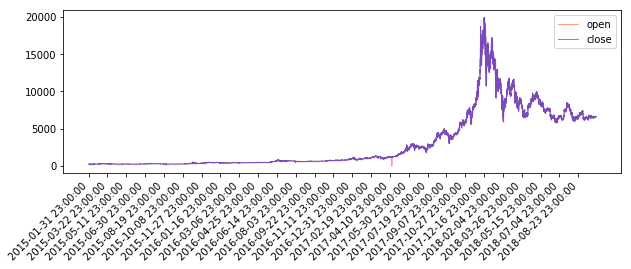

In [11]:
data5m = pd.read_csv(
    BC5M_FILENAME,
    index_col='timestamp',
    parse_dates=['datetime']
)
print('> size:', len(data5m))
dd(data5m.dtypes)
dd(data5m.head())
dd(data5m.tail())
simple_plot(data5m, xticks_span=30 * 24 * 60 // 3)

In [16]:
data5m['weekday'] = data5m.datetime.dt.dayofweek

## Test runs

### LSTM

data ~ (28000, 6)
--- 0.014s to model compilation time


--- Created model id: 139915290323152
Tensor("lstm_9_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 100)          42800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
__________________________________________________

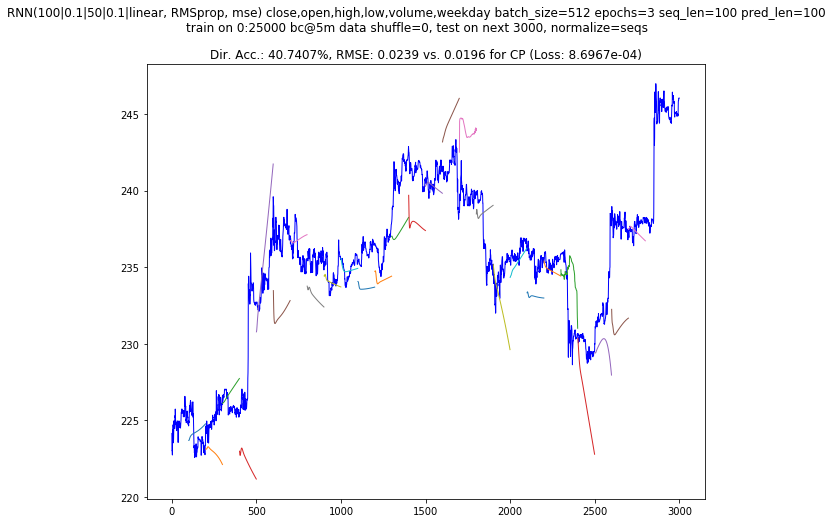

--- 93.528s to run experiment



In [21]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday'],
        from_i=0,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (28000, 6)
--- 0.015s to model compilation time


--- Created model id: 139915551981392
Tensor("lstm_5_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100, 100)          42800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
__________________________________________________

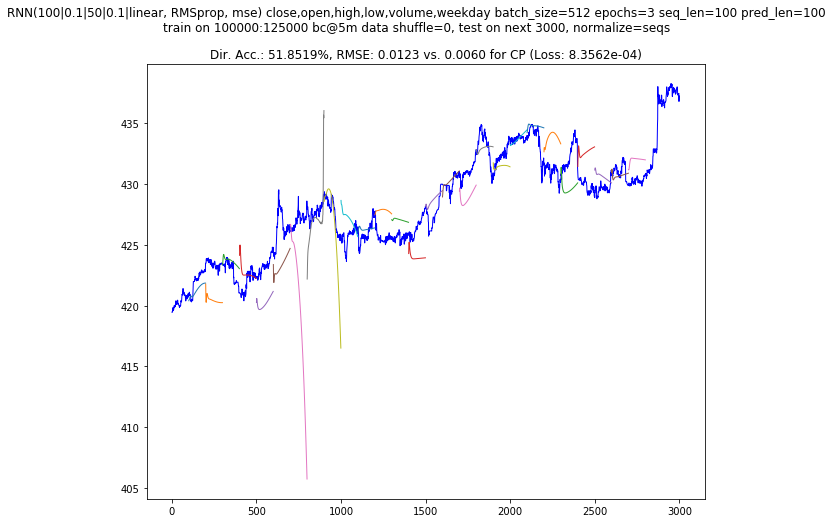

--- 105.233s to run experiment



In [19]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday'],
        from_i=100000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (28000, 6)
--- 0.019s to model compilation time


--- Created model id: 139915589180752
Tensor("lstm_3_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 100)          42800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
__________________________________________________

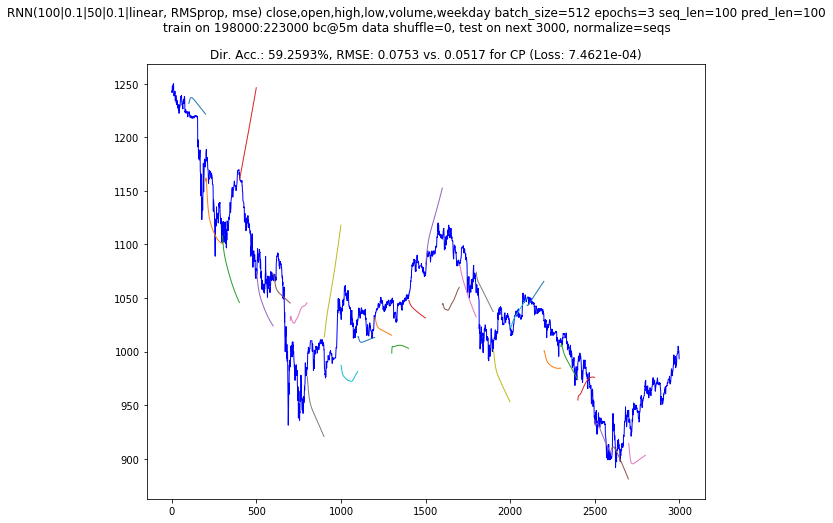

--- 106.737s to run experiment



In [18]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday'],
        from_i=198000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (28000, 6)
--- 0.015s to model compilation time


--- Created model id: 139915588537168
Tensor("lstm_7_input:0", shape=(?, 100, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100, 100)          42800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
__________________________________________________

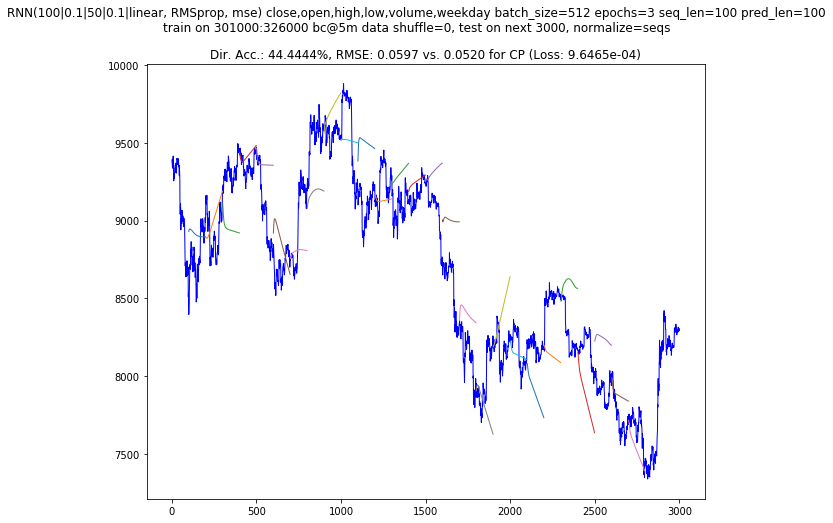

--- 93.540s to run experiment



In [20]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data5m,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday'],
        from_i=301000,
        train_sz=25000,
        test_sz=3000,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=100,
        pred_len=100,
        model_maker=make_rnn_model_constructor([100, 0.1, 50, 0.1]),
        # training:
        epochs=3,
        batch_size=512,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=True,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )